Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.
Training AMFF-CNN...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.1764 - loss: 1.7853 - val_accuracy: 0.3494 - val_loss: 1.5821
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.3939 - loss: 1.4339 - val_accuracy: 0.4858 - val_loss: 1.1177
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5056 - loss: 1.1364 - val_accuracy: 0.5994 - val_loss: 0.9159
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7223 - loss: 0.7638 - val_accuracy: 0.8409 - val_loss: 0.5377
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7681 - loss: 0.6254 - val_accuracy: 0.9176 - val_loss: 0.3614
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8369 - loss: 0.4406 - val_accuracy: 0.9148 - val_loss: 0.2588
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8511 - loss: 0.3989 - val_accuracy: 0.7841 - val_loss: 0.5543
Epoch 

C:\Users\rites\AppData\Local\Temp\ipykernel_4936\881195410.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


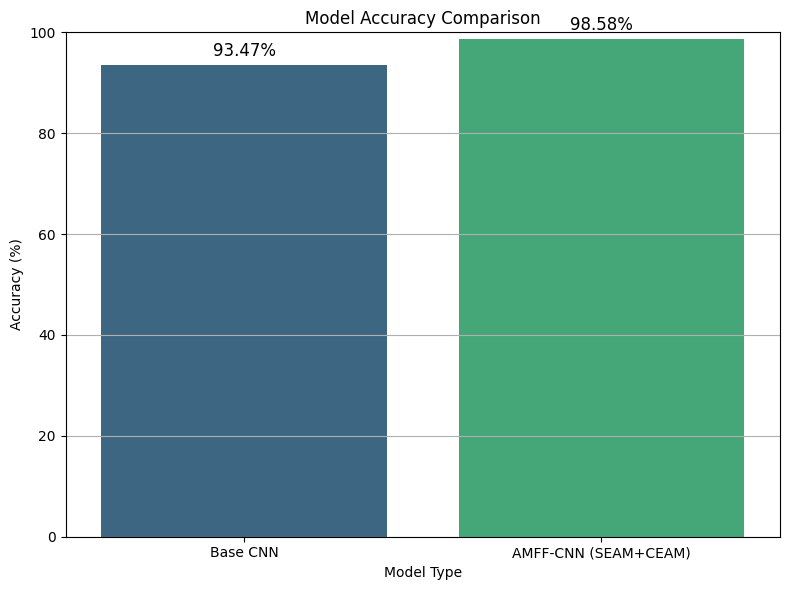

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns


img_size = 128
batch_size = 32
epochs = 100
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
num_classes = len(class_names)
input_shape = (img_size, img_size, 3)
images_dir = r"C:\Users\rites\OneDrive\Desktop\New Defect\NEU-DET\IMAGES"


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size



def seam_module(input_tensor, filters):
    d1 = layers.Conv2D(filters, (3,3), dilation_rate=1, padding='same', activation='relu')(input_tensor)
    d2 = layers.Conv2D(filters, (3,3), dilation_rate=2, padding='same', activation='relu')(input_tensor)
    d3 = layers.Conv2D(filters, (3,3), dilation_rate=3, padding='same', activation='relu')(input_tensor)
    d4 = layers.Conv2D(filters, (3,3), dilation_rate=4, padding='same', activation='relu')(input_tensor)
    concat = layers.Concatenate()([d1, d2, d3, d4])
    conv_fused = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(concat)

    gap = layers.GlobalAveragePooling2D()(conv_fused)
    dense_1 = layers.Dense(filters // 8, activation='relu')(gap)
    dense_2 = layers.Dense(filters, activation='sigmoid')(dense_1)
    channel_attention = layers.Multiply()([conv_fused, layers.Reshape((1, 1, filters))(dense_2)])

    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_attention)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_attention)
    concat_spatial = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, (7,7), padding='same', activation='sigmoid')(concat_spatial)
    spatial_out = layers.Multiply()([channel_attention, spatial_attention])
    return spatial_out


def ceam_module(current, previous, filters):
    target_shape = tf.keras.backend.int_shape(current)[1:3]
    prev_resized = layers.Lambda(lambda x: tf.image.resize(x, target_shape))(previous)
    prev_resized = layers.Conv2D(filters, (1,1), padding='same')(prev_resized)
    guided = layers.Conv2D(filters, (3,3), padding='same', activation='sigmoid')(current)
    modulated = layers.Multiply()([prev_resized, guided])
    return modulated


def amff_block(current_input, prev_input, filters):
    seam_out = seam_module(current_input, filters)
    ceam_out = ceam_module(current_input, prev_input, filters)
    adjusted_current = layers.Conv2D(filters, (1, 1), padding='same')(current_input)
    combined = layers.Add()([seam_out, ceam_out, adjusted_current])
    return combined


def build_amff_cnn(input_shape=(128, 128, 3), num_classes=6):
    inputs = layers.Input(shape=input_shape)
    x1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x1 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x1)
    x2 = layers.MaxPooling2D()(x2)

    x3 = amff_block(x2, x1, 64)
    x3 = layers.MaxPooling2D()(x3)

    x4 = amff_block(x3, x2, 128)
    x4 = layers.GlobalAveragePooling2D()(x4)

    x4 = layers.Dense(128, activation='relu')(x4)
    x4 = layers.Dropout(0.5)(x4)
    outputs = layers.Dense(num_classes, activation='softmax')(x4)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def build_base_cnn(input_shape=(128, 128, 3), num_classes=6):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


print("Training AMFF-CNN...")
amff_model = build_amff_cnn(input_shape=input_shape, num_classes=num_classes)
amff_model.fit(train_generator, steps_per_epoch=steps_per_epoch,
               validation_data=val_generator, validation_steps=validation_steps, epochs=epochs)
amff_loss, amff_acc = amff_model.evaluate(val_generator, steps=validation_steps, verbose=0)
amff_acc *= 100


print("Training Base CNN...")
base_model = build_base_cnn(input_shape=input_shape, num_classes=num_classes)
base_model.fit(train_generator, steps_per_epoch=steps_per_epoch,
               validation_data=val_generator, validation_steps=validation_steps, epochs=epochs)
base_loss, base_acc = base_model.evaluate(val_generator, steps=validation_steps, verbose=0)
base_acc *= 100


model_names = ['Base CNN', 'AMFF-CNN (SEAM+CEAM)']
accuracies = [base_acc, amff_acc]

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.xlabel("Model Type")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', va='bottom', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import math


img_size = 128
batch_size = 32
epochs = 50
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
num_classes = len(class_names)
input_shape = (img_size, img_size, 3)
images_dir = r"C:\Users\rites\OneDrive\Desktop\New Defect\NEU-DET\IMAGES"

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,  
    seed=42
)

steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size



def seam_module(input_tensor, filters):
    d1 = layers.Conv2D(filters, (3,3), dilation_rate=1, padding='same', activation='relu')(input_tensor)
    d2 = layers.Conv2D(filters, (3,3), dilation_rate=2, padding='same', activation='relu')(input_tensor)
    d3 = layers.Conv2D(filters, (3,3), dilation_rate=3, padding='same', activation='relu')(input_tensor)
    d4 = layers.Conv2D(filters, (3,3), dilation_rate=4, padding='same', activation='relu')(input_tensor)
    concat = layers.Concatenate()([d1, d2, d3, d4])
    conv_fused = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(concat)

    gap = layers.GlobalAveragePooling2D()(conv_fused)
    dense_1 = layers.Dense(filters // 8, activation='relu')(gap)
    dense_2 = layers.Dense(filters, activation='sigmoid')(dense_1)
    channel_attention = layers.Multiply()([conv_fused, layers.Reshape((1, 1, filters))(dense_2)])

    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_attention)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_attention)
    concat_spatial = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, (7,7), padding='same', activation='sigmoid')(concat_spatial)
    spatial_out = layers.Multiply()([channel_attention, spatial_attention])
    return spatial_out

def ceam_module(current, previous, filters):
    target_shape = tf.keras.backend.int_shape(current)[1:3]
    prev_resized = layers.Lambda(lambda x: tf.image.resize(x, target_shape))(previous)
    prev_resized = layers.Conv2D(filters, (1,1), padding='same')(prev_resized)
    guided = layers.Conv2D(filters, (3,3), padding='same', activation='sigmoid')(current)
    modulated = layers.Multiply()([prev_resized, guided])
    return modulated

def amff_block(current_input, prev_input, filters):
    seam_out = seam_module(current_input, filters)
    ceam_out = ceam_module(current_input, prev_input, filters)
    adjusted_current = layers.Conv2D(filters, (1, 1), padding='same')(current_input)
    combined = layers.Add()([seam_out, ceam_out, adjusted_current])
    return combined

def build_amff_cnn(input_shape=(128, 128, 3), num_classes=6):
    inputs = layers.Input(shape=input_shape)
    x1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x1 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x1)
    x2 = layers.MaxPooling2D()(x2)

    x3 = amff_block(x2, x1, 64)
    x3 = layers.MaxPooling2D()(x3)

    x4 = amff_block(x3, x2, 128)
    x4 = layers.GlobalAveragePooling2D()(x4)

    x4 = layers.Dense(128, activation='relu')(x4)
    x4 = layers.Dropout(0.5)(x4)
    outputs = layers.Dense(num_classes, activation='softmax')(x4)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_base_cnn(input_shape=(128, 128, 3), num_classes=6):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("Training AMFF-CNN...")
amff_model = build_amff_cnn(input_shape=input_shape, num_classes=num_classes)
amff_model.fit(train_generator, steps_per_epoch=steps_per_epoch,
               validation_data=val_generator, validation_steps=validation_steps, epochs=epochs)
amff_loss, amff_acc = amff_model.evaluate(val_generator, steps=validation_steps, verbose=0)
amff_acc *= 100

print("Training Base CNN...")
base_model = build_base_cnn(input_shape=input_shape, num_classes=num_classes)
base_model.fit(train_generator, steps_per_epoch=steps_per_epoch,
               validation_data=val_generator, validation_steps=validation_steps, epochs=epochs)
base_loss, base_acc = base_model.evaluate(val_generator, steps=validation_steps, verbose=0)
base_acc *= 100

def get_all_predictions(model, generator, class_names):
    generator.reset()
    predictions = []
    total = generator.samples
    for i in range(len(generator)):
        images, labels = generator[i]
        preds = model.predict(images, verbose=0)
        pred_labels = np.argmax(preds, axis=1)
        true_labels = np.argmax(labels, axis=1)
        for j in range(len(images)):
            predictions.append((images[j], class_names[true_labels[j]], class_names[pred_labels[j]]))
            if len(predictions) >= total:
                break
    return predictions

def plot_predictions(predictions, title, batch_size=25):
    total_images = len(predictions)
    batches = math.ceil(total_images / batch_size)
    for b in range(batches):
        start = b * batch_size
        end = min(start + batch_size, total_images)
        plt.figure(figsize=(15, 15))
        for i, (img, true_label, pred_label) in enumerate(predictions[start:end]):
            plt.subplot(5, 5, i + 1)
            plt.imshow(img)
            is_correct = (true_label == pred_label)
            color = 'green' if is_correct else 'red'
            plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=8, color=color)
            plt.axis('off')
        plt.suptitle(f"{title} - Batch {b+1}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()



print("Displaying AMFF-CNN predictions...")
amff_predictions = get_all_predictions(amff_model, val_generator, class_names)
plot_predictions(amff_predictions, title="AMFF-CNN Predictions")
 
print("Displaying Base CNN predictions...")
base_predictions = get_all_predictions(base_model, val_generator, class_names)
plot_predictions(base_predictions, title="Base CNN Predictions")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

Classification Report (Base CNN):

                 precision    recall  f1-score   support

        crazing       1.00      1.00      1.00        59
      inclusion       0.92      1.00      0.96        57
        patches       1.00      1.00      1.00        60
 pitted_surface       0.98      0.92      0.95        60
rolled-in_scale       1.00      0.98      0.99        58
      scratches       1.00      1.00      1.00        58

       accuracy                           0.98       352
      macro avg       0.98      0.98      0.98       352
   weighted avg       0.98    

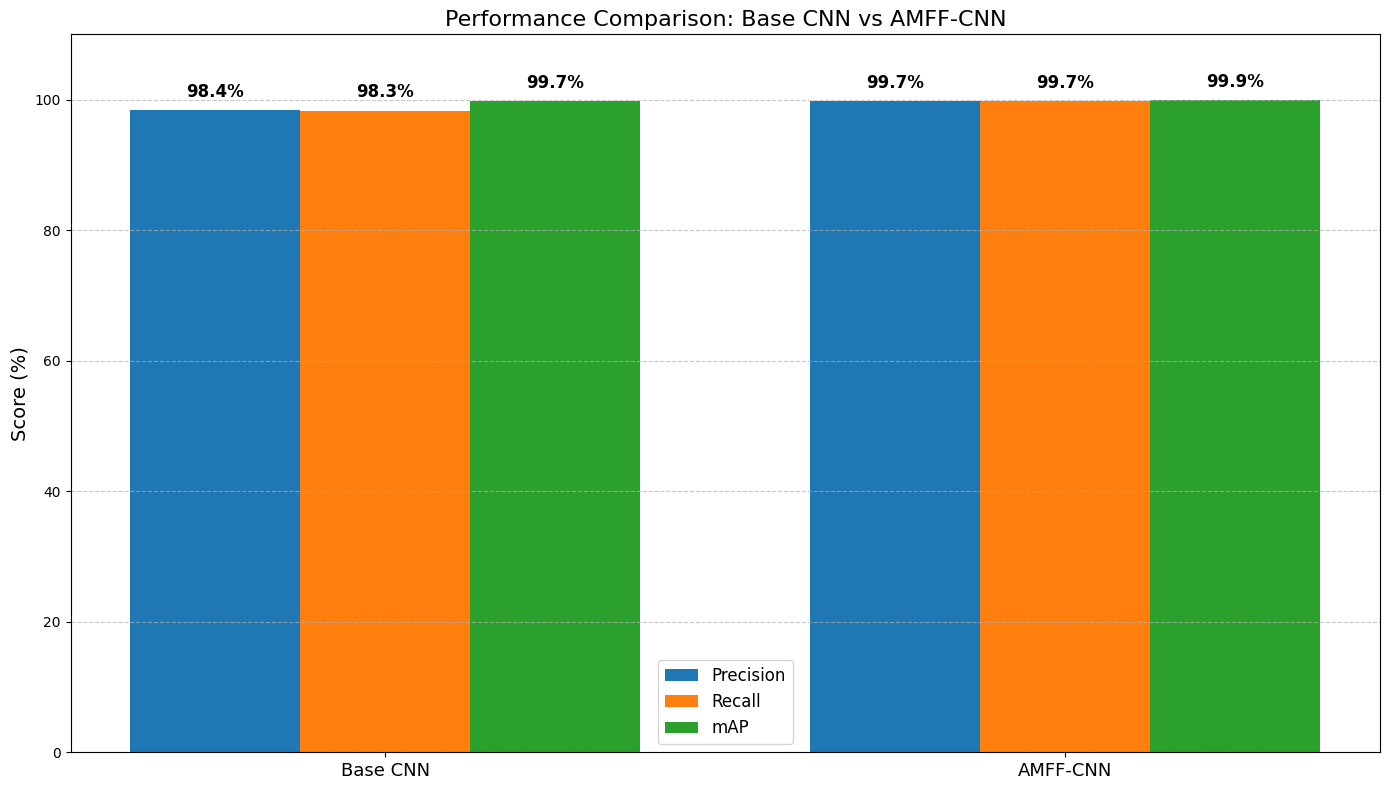

In [5]:
from sklearn.metrics import classification_report, precision_score, recall_score, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, name):
    val_generator.reset()
    y_true, y_pred, y_scores = [], [], []

    for _ in range(validation_steps):
        images, labels = next(val_generator)
        preds = model.predict(images)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        y_scores.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    print(f"\nClassification Report ({name}):\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    precision = precision_score(y_true, y_pred, average='macro') * 100
    recall = recall_score(y_true, y_pred, average='macro') * 100
    map_score = average_precision_score(y_true_bin, y_scores, average='macro') * 100

    print(f"Macro Precision: {precision:.2f}%")
    print(f"Macro Recall: {recall:.2f}%")
    print(f"Mean Average Precision (mAP): {map_score:.2f}%")

    return precision, recall, map_score


precision_base, recall_base, map_base = evaluate_model(base_model, "Base CNN")
precision_amff, recall_amff, map_amff = evaluate_model(amff_model, "AMFF-CNN")


models = ['Base CNN', 'AMFF-CNN']
metrics = {
    'Precision': [precision_base, precision_amff],
    'Recall': [recall_base, recall_amff],
    'mAP': [map_base, map_amff]
}

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(14, 8))  
for i, (metric, values) in enumerate(metrics.items()):
    plt.bar(x + (i - 1) * width, values, width, label=metric)

plt.xticks(x, models, fontsize=13)
plt.ylim(0, 110)  
plt.ylabel('Score (%)', fontsize=14)
plt.title('Performance Comparison: Base CNN vs AMFF-CNN', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


for i in range(len(models)):
    for j, (metric, values) in enumerate(metrics.items()):
        plt.text(x[i] + (j - 1) * width, values[i] + 2,
                 f"{values[i]:.1f}%", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9980 - loss: 0.0080 - val_accuracy: 0.9801 - val_loss: 0.0501
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9968 - loss: 0.0150 - val_accuracy: 0.9915 - val_loss: 0.0385
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9149 - loss: 0.2704 - val_accuracy: 0.9943 - val_loss: 0.0358
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9805 - loss: 0.0526 - val_accuracy: 0.9943 - val_loss: 0.0280
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9965 - loss: 0.0166 - val_accuracy: 0.9972 - val_loss: 0.0117
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9885 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9950 - loss: 0.0154 - val_accuracy: 0.9915 - val_loss: 0.0345
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9884 - loss: 0.0463 - val_accuracy: 0.9801 - v

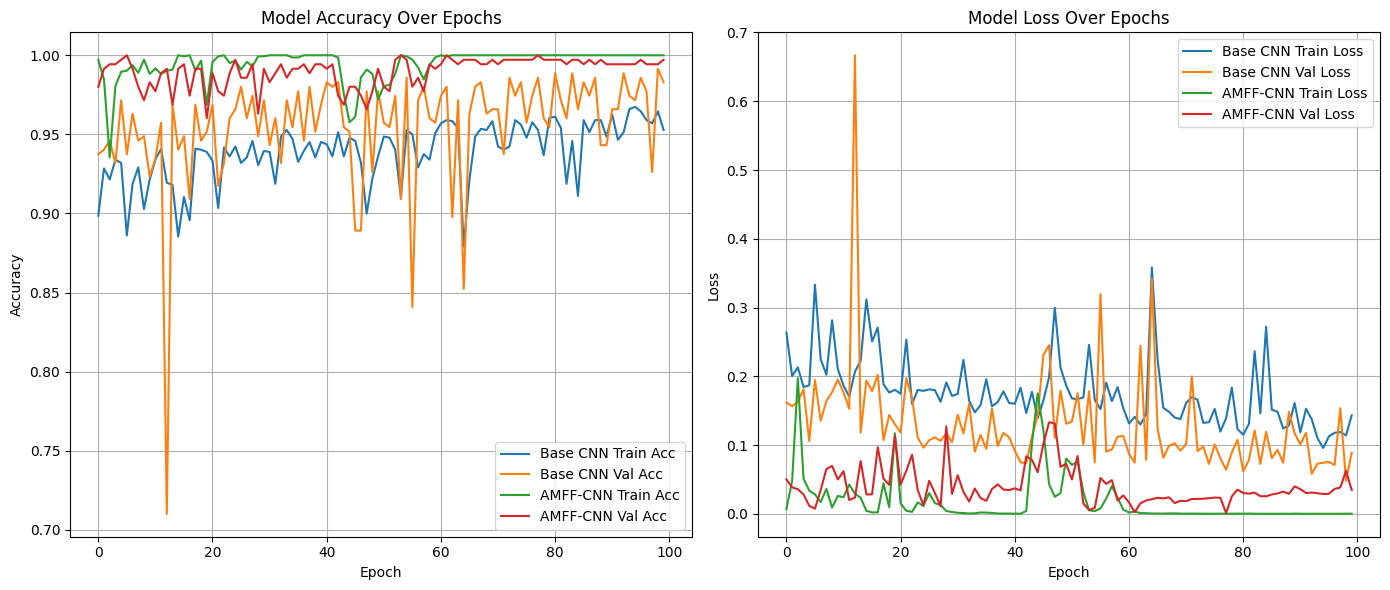

In [4]:
history_amff = amff_model.fit(train_generator, steps_per_epoch=steps_per_epoch,
                              validation_data=val_generator, validation_steps=validation_steps, epochs=epochs, verbose=1)

history_base = base_model.fit(train_generator, steps_per_epoch=steps_per_epoch,
                              validation_data=val_generator, validation_steps=validation_steps, epochs=epochs, verbose=1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Base CNN Train Acc')
plt.plot(history_base.history['val_accuracy'], label='Base CNN Val Acc')
plt.plot(history_amff.history['accuracy'], label='AMFF-CNN Train Acc')
plt.plot(history_amff.history['val_accuracy'], label='AMFF-CNN Val Acc')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Base CNN Train Loss')
plt.plot(history_base.history['val_loss'], label='Base CNN Val Loss')
plt.plot(history_amff.history['loss'], label='AMFF-CNN Train Loss')
plt.plot(history_amff.history['val_loss'], label='AMFF-CNN Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [6]:

base_train_acc = history_base.history['accuracy'][-1] * 100
base_val_acc = history_base.history['val_accuracy'][-1] * 100
base_train_loss = history_base.history['loss'][-1]
base_val_loss = history_base.history['val_loss'][-1]

print(f"Base CNN Train Accuracy: {base_train_acc:.2f}%")
print(f"Base CNN Validation Accuracy: {base_val_acc:.2f}%")
print(f"Base CNN Train Loss: {base_train_loss:.4f}")
print(f"Base CNN Validation Loss: {base_val_loss:.4f}")

print("\n")

amff_train_acc = history_amff.history['accuracy'][-1] * 100
amff_val_acc = history_amff.history['val_accuracy'][-1] * 100
amff_train_loss = history_amff.history['loss'][-1]
amff_val_loss = history_amff.history['val_loss'][-1]

print(f"AMFF-CNN Train Accuracy: {amff_train_acc:.2f}%")
print(f"AMFF-CNN Validation Accuracy: {amff_val_acc:.2f}%")
print(f"AMFF-CNN Train Loss: {amff_train_loss:.4f}")

Base CNN Train Accuracy: 95.28%
Base CNN Validation Accuracy: 98.30%
Base CNN Train Loss: 0.1434
Base CNN Validation Loss: 0.0891


AMFF-CNN Train Accuracy: 100.00%
AMFF-CNN Validation Accuracy: 99.72%
AMFF-CNN Train Loss: 0.0002
